In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm
import theano.tensor as tt

import matplotlib.dates as mdates
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler, scale
import pickle
from collections import namedtuple
from numpy import pi as PI

In [2]:
% matplotlib inline

As a first attempt I am going to model the timeseries using a Gaussian Random Walk.
I am also going to impute the missing data by modeling it

In [3]:
years = mdates.YearLocator(day=15)
months = mdates.MonthLocator(bymonthday=15)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18

In [4]:
chl_file = './dataJar/seawifs_chl_monthly_15sosectors_repro2018.dat'
df = pd.read_csv(chl_file, delim_whitespace=True, parse_dates=[[0, 1 ,2]], index_col=0)

df.index.name=''
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 1997-09-15 to 2010-12-16
Data columns (total 15 columns):
IOSTZ      155 non-null float64
IOSAZ      155 non-null float64
IOPFZ      155 non-null float64
IOAAZ      148 non-null float64
IOSAACZ    123 non-null float64
POSTZ      155 non-null float64
POSAZ      155 non-null float64
POPFZ      124 non-null float64
POAAZ      118 non-null float64
POSAACZ    99 non-null float64
AOSTZ      153 non-null float64
AOSAZ      153 non-null float64
AOPFZ      152 non-null float64
AOAAZ      139 non-null float64
AOSAAC     126 non-null float64
dtypes: float64(15)
memory usage: 19.5 KB


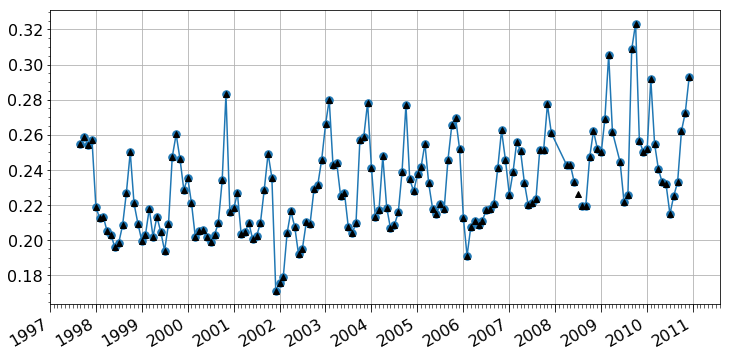

In [8]:
_, ax = pl.subplots(figsize=(12, 6))
df.IOSTZ.plot(marker='.', ax=ax, markersize=15)
df.IOSTZ.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

In [5]:
d_iostz = df['IOSTZ'].resample('MS').mean().interpolate()
d_iostz.shape

(160,)

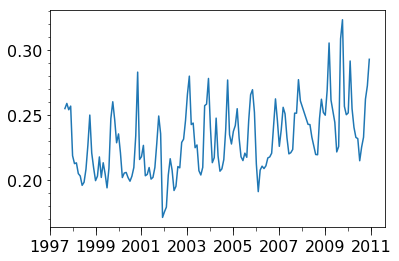

In [10]:
d_iostz.plot();

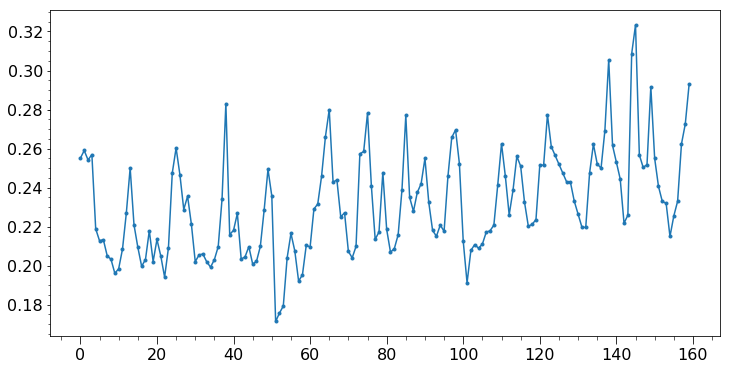

In [6]:
y = d_iostz.values
wl = 12/(2*np.pi)
x = np.arange(y.size)
f = pl.figure(figsize=(12, 6))
pl.plot(x, y, marker='.');

#### <u>Standardizing the Data</u>

In [7]:
std_scaler = StandardScaler()
y_s = std_scaler.fit_transform(y.reshape(-1, 1))
y_s = y_s.flatten()

### Modeling Trends
#### <u>Basic Trend Models</u>

In [23]:
with pm.Model() as m1:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y)

In [24]:
with m1:
    trace1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, tau_log__, nuMinusOne_log__]
100%|██████████| 2000/2000 [00:07<00:00, 253.26it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '22152' (I am process '22153')
INFO (theano.gof.compilelock): To manually release the lock, delete /accounts/ekarakoy/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.5-64/lock_dir


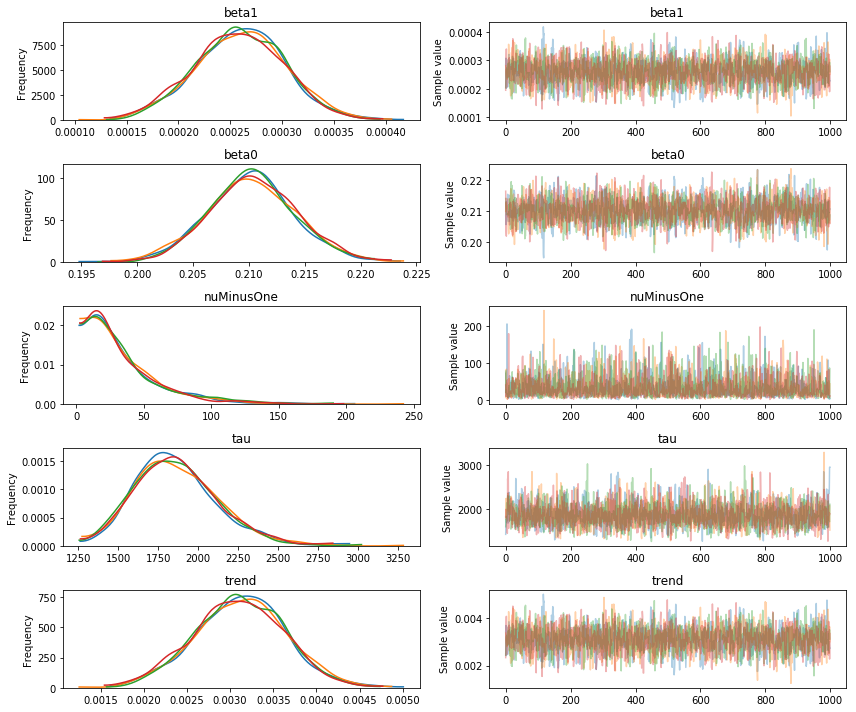

In [26]:
pm.traceplot(trace1);

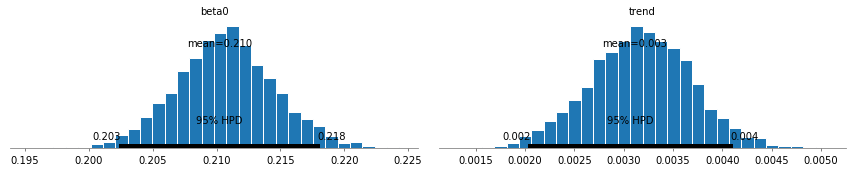

In [28]:
pm.plot_posterior(trace1, varnames=['beta0', 'trend']);

In [31]:
with pm.Model() as m1n:
    sig = pm.HalfNormal('sig', 5)
    beta1 = pm.Normal('beta1', 0, 10)
    beta0 = pm.Normal('beta0', 0, 10)
    trend = pm.Deterministic('trend', beta1 * 12)
    mu_ = beta0 + beta1 * x
    y_lik = pm.Normal('y_lik', mu=mu_, sd=sig, observed=y)

In [33]:
with m1n:
    trace_1n = pm.sample(1000, tune=1000, nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sig_log__]
100%|██████████| 2000/2000 [00:03<00:00, 580.87it/s]


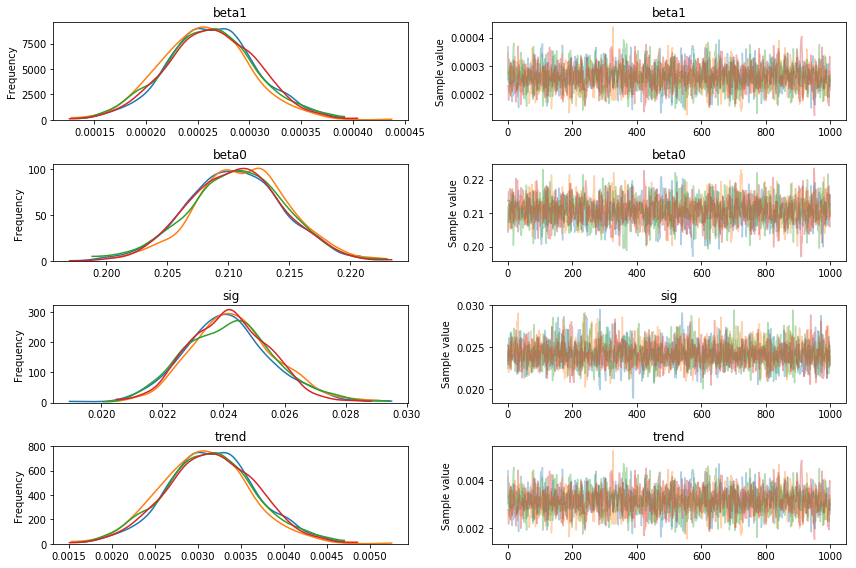

In [34]:
pm.traceplot(trace_1n);

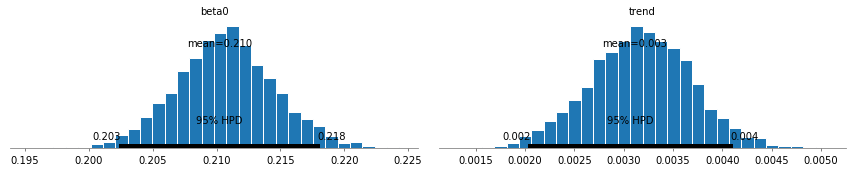

In [35]:
pm.plot_posterior(trace1, varnames=['beta0', 'trend']);


 #### <u>Piecewise trend model</u>

### Seasonality
#### <u> single cosine with fixed wavelength</u>

In [97]:
with pm.Model() as m2_s:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    tau = pm.Gamma('tau', 10, 2)
    mu_ = amp * tt.cos((x - thresh)/ wl)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

In [98]:
with m2_s:
    trace_2_s = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, amp_interval__, thresh_interval__, nuMinusOne_log__]
100%|██████████| 3000/3000 [00:03<00:00, 840.89it/s]


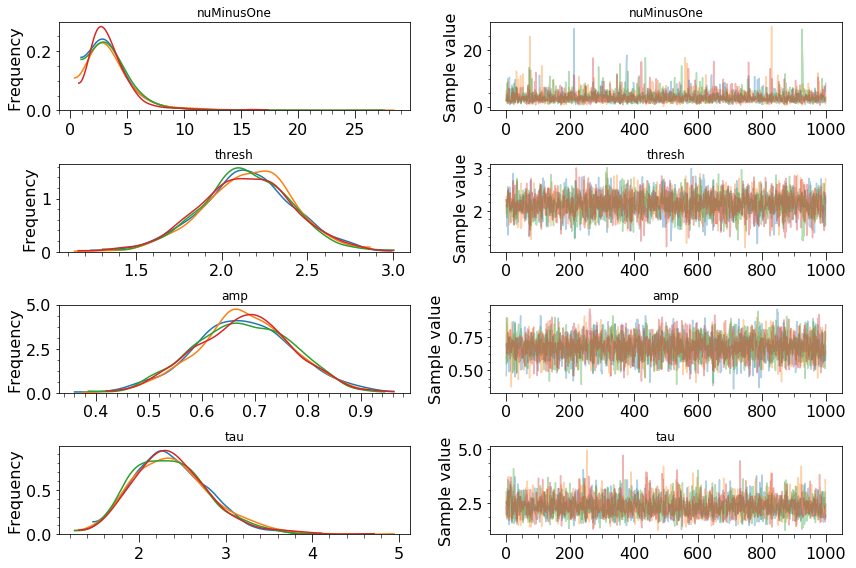

In [99]:
pm.traceplot(trace_2_s);

#### <u>Single sinuoid with inferred wavelength</u>

In [15]:
wl_lower = 11 / (2 * np.pi)
wl_upper = 13 / (2 * np.pi)

In [124]:
with pm.Model() as m2b_s:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.HalfNormal('amp', 1)
    tau = pm.Gamma('tau', 10, 2)
    mu_ = amp * tt.cos((x - thresh)/ wl_)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

In [125]:
with m2b_s:
    trace_2b_s = pm.sample(2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, amp_log__, thresh_interval__, wl_interval__, nuMinusOne_log__]
100%|██████████| 5000/5000 [00:08<00:00, 584.19it/s]


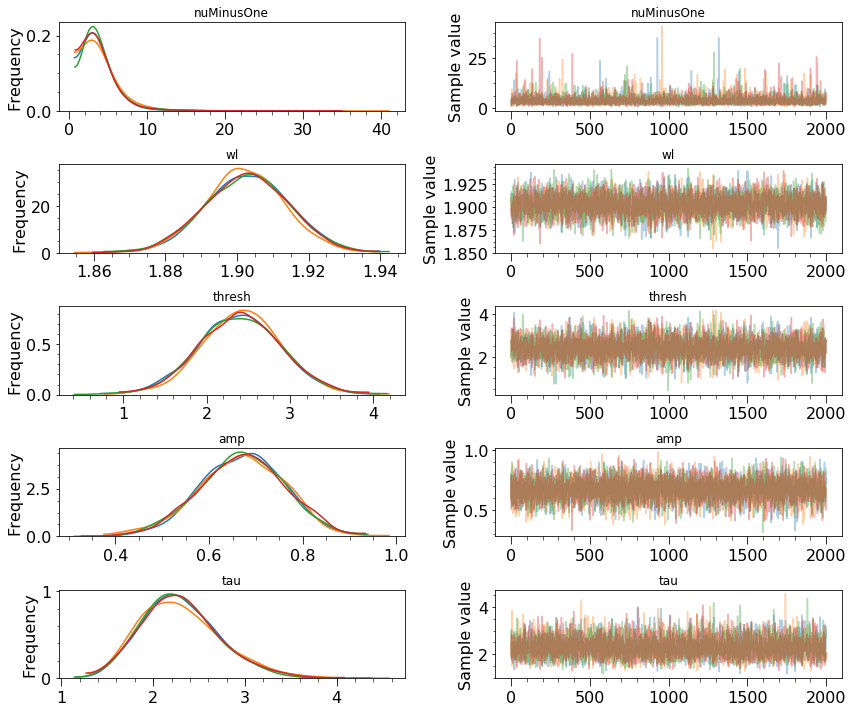

In [126]:
pm.traceplot(trace_2b_s);

#### <u>Seasonality based on Fourier Series</u>

In [245]:
N=3
sinusoids = np.array([np.cos(2*np.pi *k / 12) for k in range(1, N+1)])

In [248]:
wls = [2*np.pi *k / 12 for k in range(1, N+1)]

In [251]:
sinusoids = np.array([[np.cos(wli), np.sin(wli)] for wli in wls])

In [255]:
t= np.arange(0, 10)

In [280]:
precomp = np.array([[np.cos(wli * t), np.sin(wli*t)] for wli in wls]).reshape(N*2, 10).T.shape

In [279]:
sinusoids = sinusoids.reshape(N*2,1)
sinusoids.shape

(6, 1)

In [300]:
N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [301]:
with m2_fourier:
    trace_m2f = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, fourier_coefs, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:12<00:00, 810.14it/s]


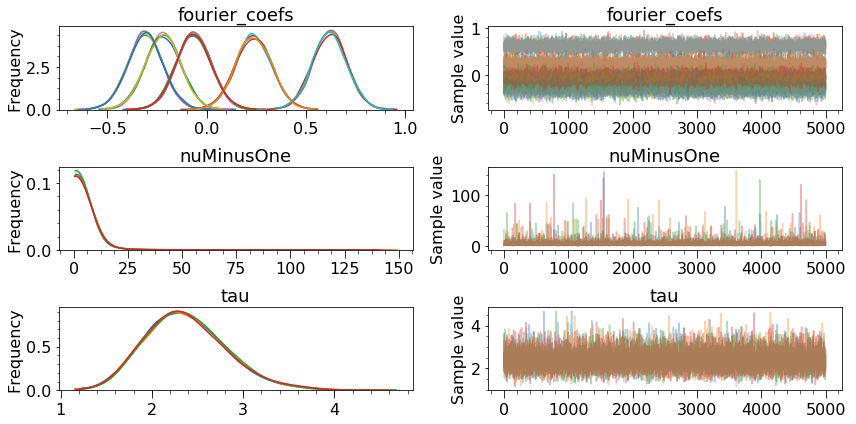

In [302]:
pm.traceplot(trace_m2f);

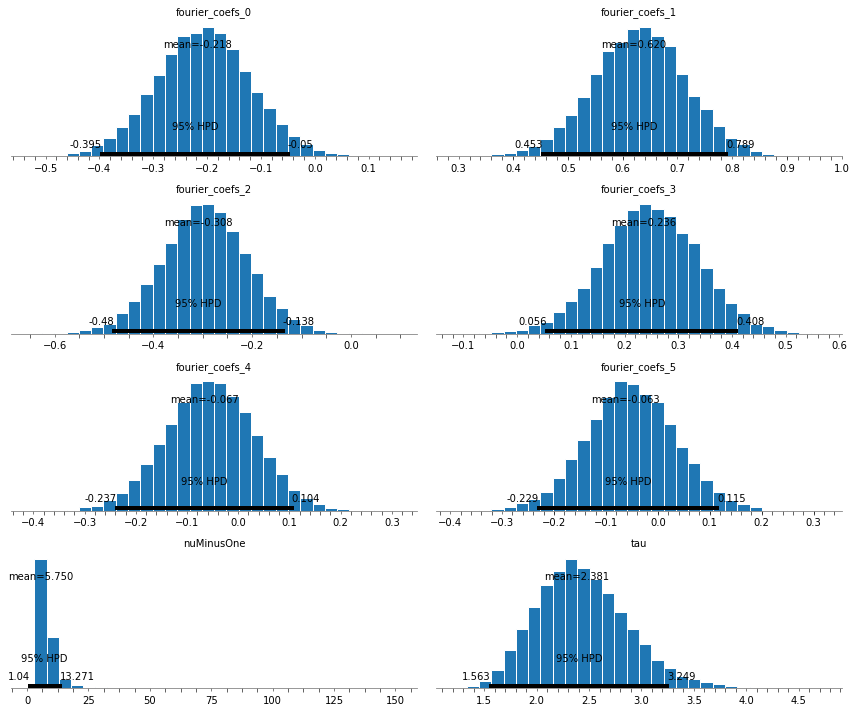

In [305]:
pm.plot_posterior(trace_m2f);

In [307]:
N=2
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier_2:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [308]:
with m2_fourier_2:
    trace_m2f2 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, fourier_coefs, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:11<00:00, 852.87it/s]


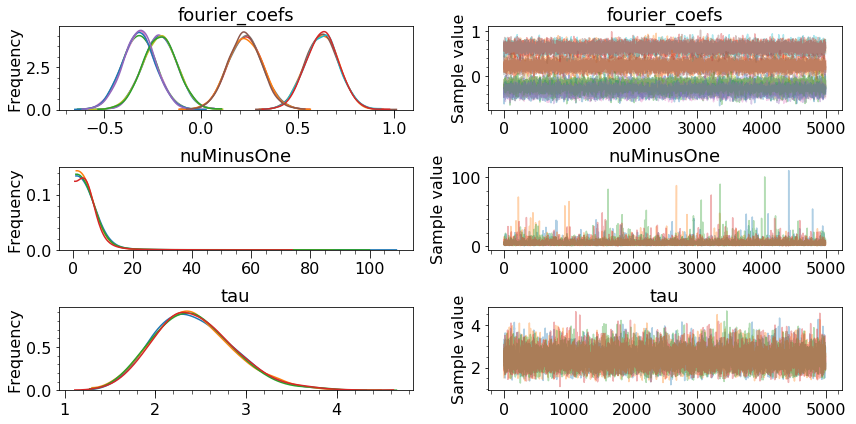

In [309]:
pm.traceplot(trace_m2f2);

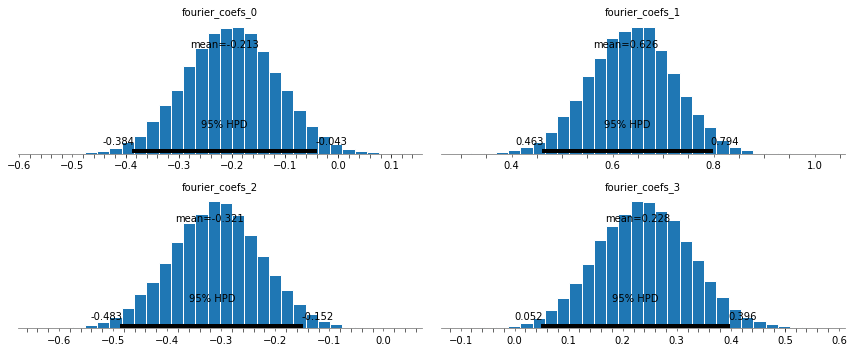

In [311]:
pm.plot_posterior(trace_m2f2, varnames=['fourier_coefs']);

In [318]:
N=5
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier_3:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [319]:
with m2_fourier_3:
    trace_m2f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, fourier_coefs, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:13<00:00, 747.25it/s]
The acceptance probability does not match the target. It is 0.68082657592, but should be close to 0.8. Try to increase the number of tuning steps.


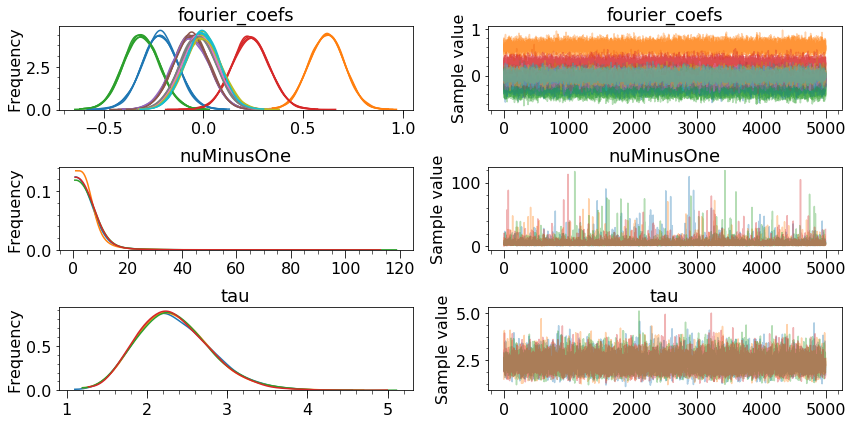

In [320]:
pm.traceplot(trace_m2f3);

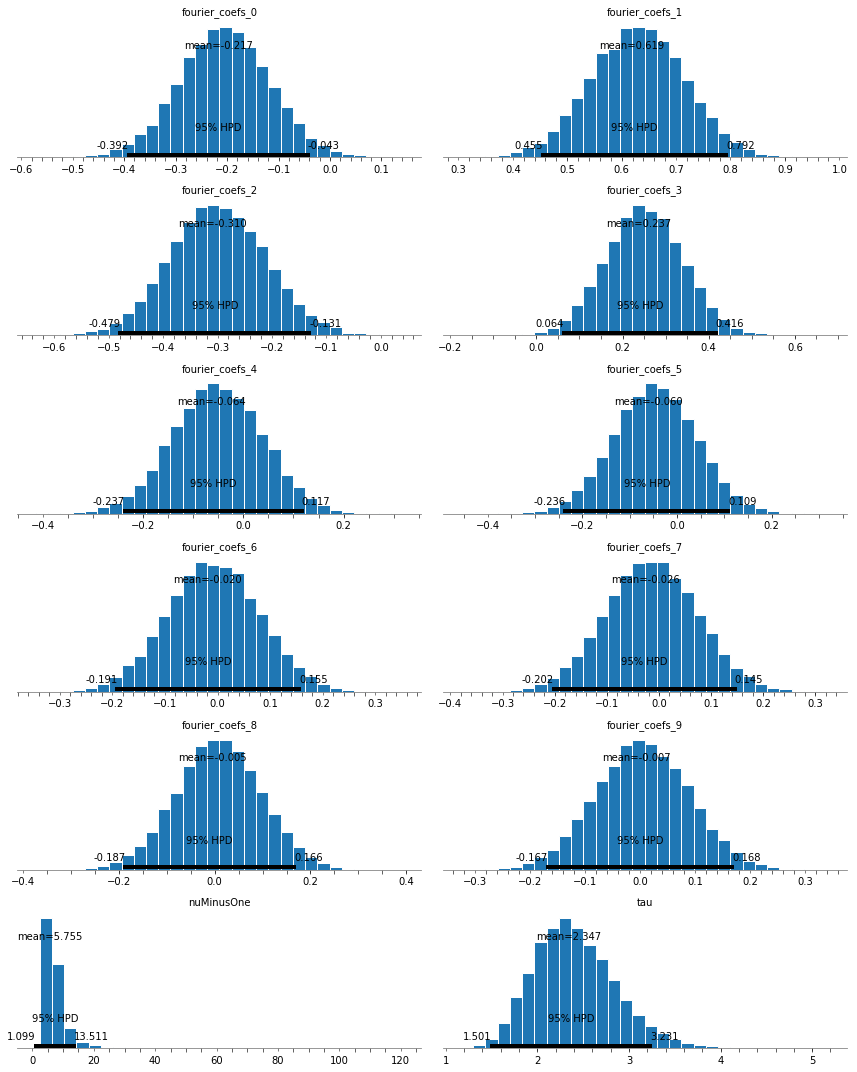

In [321]:
pm.plot_posterior(trace_m2f3);

In [312]:
N=10
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier_4:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [313]:
with m2_fourier_4:
    trace_m2f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, fourier_coefs, nuMinusOne_log__]
100%|██████████| 10000/10000 [01:27<00:00, 114.64it/s]


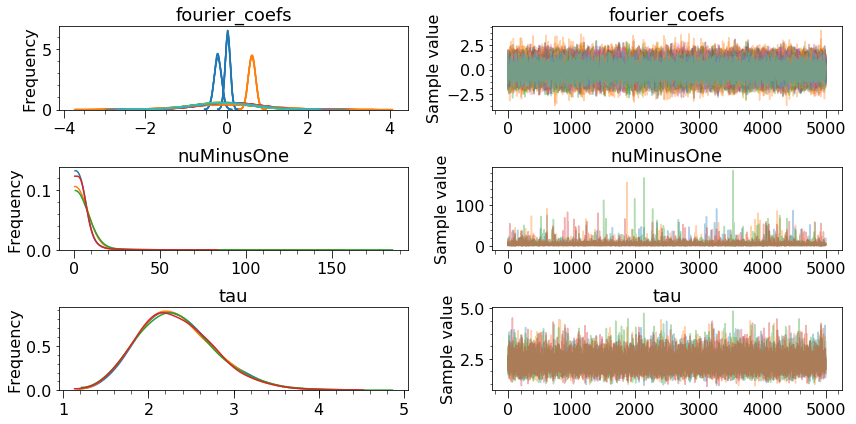

In [315]:
pm.traceplot(trace_m2f4);

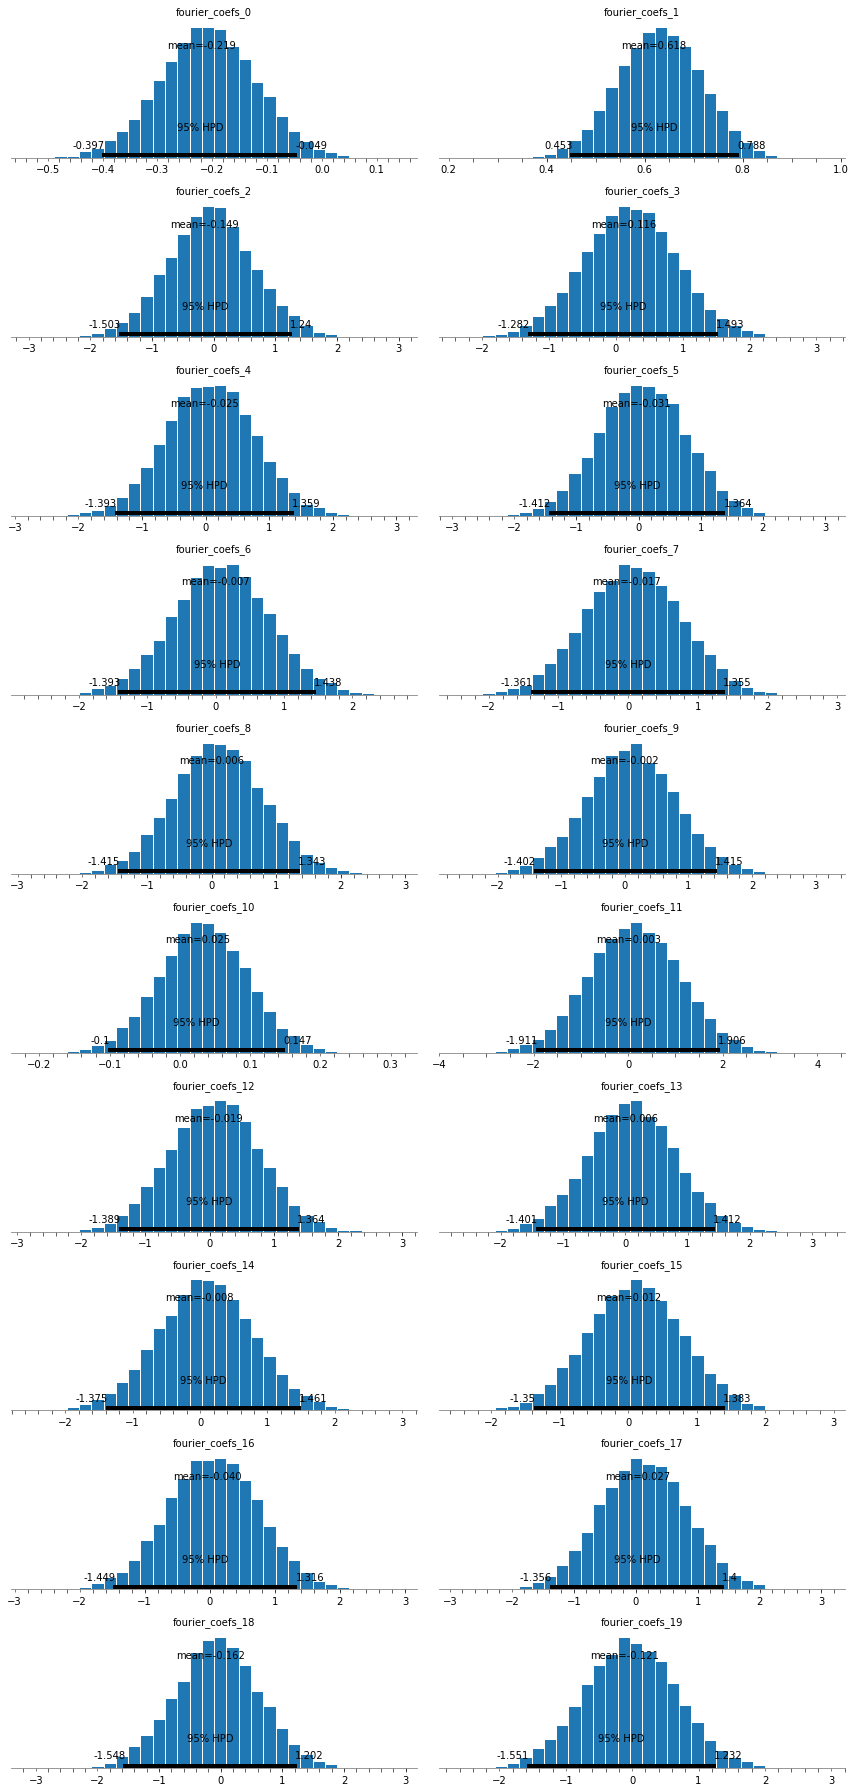

In [317]:
pm.plot_posterior(trace_m2f4, varnames=['fourier_coefs']);

In [323]:
N=1
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T

with pm.Model() as m2_fourier_1:
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = tt.dot(sinusoids, f_coefs)
    tau = pm.Gamma('tau', 10, 2) 
    y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)

In [324]:
with m2_fourier_1:
    trace_m2f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_log__, fourier_coefs, nuMinusOne_log__]
100%|██████████| 10000/10000 [00:11<00:00, 834.03it/s]
The acceptance probability does not match the target. It is 0.715269453391, but should be close to 0.8. Try to increase the number of tuning steps.


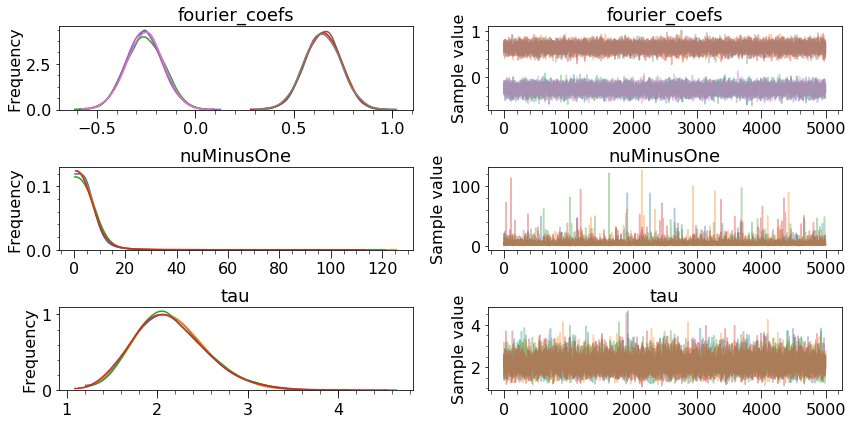

In [325]:
pm.traceplot(trace_m2f1);

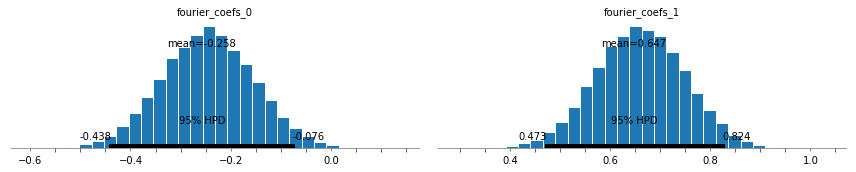

In [326]:
pm.plot_posterior(trace_m2f1, varnames=['fourier_coefs']);

In [327]:
m2_fourier_1.name = 'm_fourier_N1'
m2_fourier.name = 'm_fourier_N3'
m2_fourier_2.name = 'm_fourier_N2'
m2_fourier_3.name = 'm_fourier_N5'
m2_fourier_4.name = 'm_fourier_N10'
pm.compare({m2_fourier: trace_m2f, m2_fourier_2: trace_m2f2,
           m2_fourier_3: trace_m2f3, m2_fourier_4: trace_m2f4,
           m2_fourier_1: trace_m2f1})

WAIC  pWAIC  dWAIC weight     SE   dSE var_warn
m_fourier_N2   400.97   6.32      0   0.89  24.49     0        0
m_fourier_N3   404.36   8.73   3.39      0  24.18  2.37        0
m_fourier_N5   413.36  13.57  12.39      0  24.03  2.26        0
m_fourier_N10  415.82  14.98  14.85      0  24.03  2.52        0
m_fourier_N1   417.29    4.1  16.32   0.11  24.44  9.13        0

### Trend + Seasonality

In [37]:
with pm.Model() as m3:
    # seasonality
    thresh = pm.Uniform('thresh', -6, 6)
    amp = pm.Uniform('amp', 0, 1)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh) / wl))
    
    slp = pm.Normal('slope', 0, 10)
    itc = pm.Normal('intercept', 0, 10)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # likelihood
    tau = pm.Gamma('tau', 10, 2)
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    mu_ = trend + season
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=tau, nu=nu_, observed=y_s)

In [38]:
with m3:
    trace_3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nuMinusOne_log__, tau_log__, intercept, slope, amp_interval__, thresh_interval__]
100%|██████████| 10000/10000 [00:26<00:00, 379.22it/s]


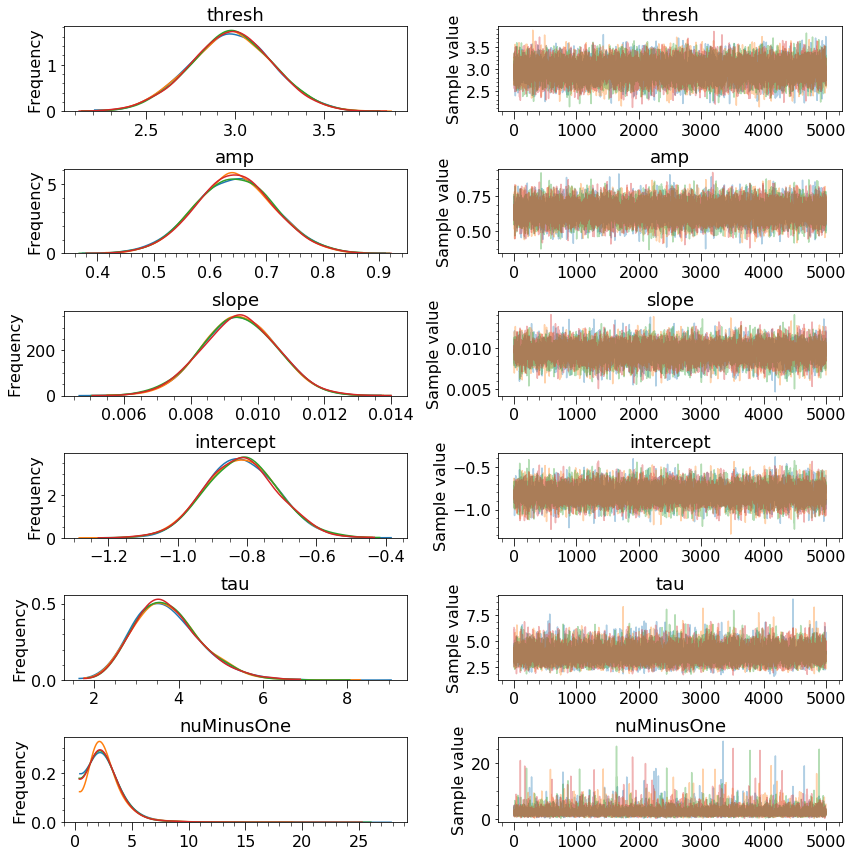

In [39]:
vars_ = ['thresh', 'amp', 'slope', 'intercept', 'tau', 'nuMinusOne']
pm.traceplot(trace_3, varnames=vars_);

#### <u>Simple trend and fourier seasonality</u>

In [17]:
N=1
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T
with pm.Model() as m3_f1:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [18]:
with m3_f1:
    trace_3f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_log__, nuMinusOne_log__, intercept, slope, fourier_coefs]
100%|██████████| 10000/10000 [00:21<00:00, 468.24it/s]


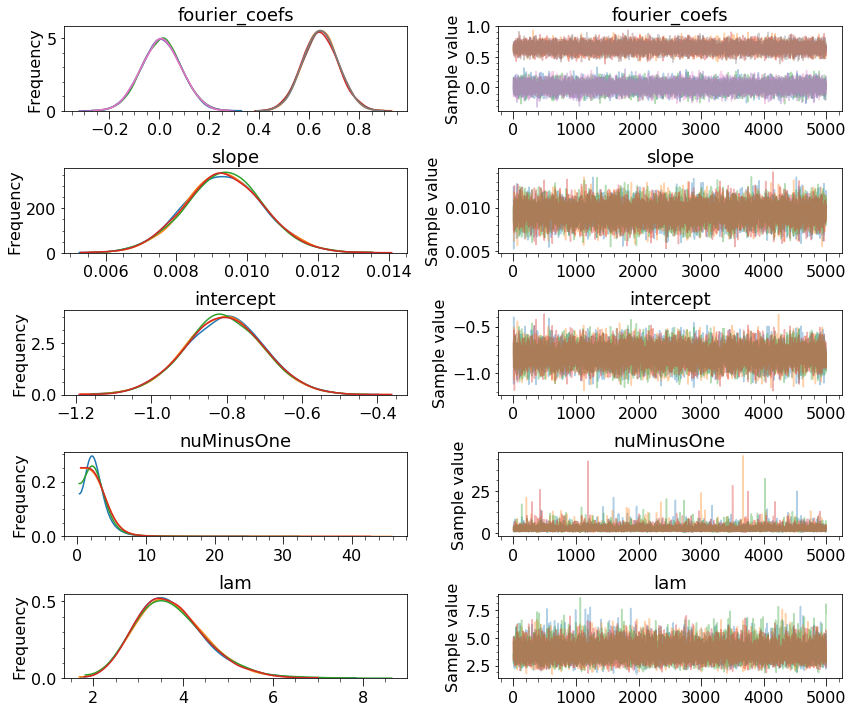

In [19]:
vars_ = ['fourier_coefs', 'slope', 'intercept', 'nuMinusOne', 'lam']
pm.traceplot(trace_3f1, varnames=vars_);

In [20]:
N=2
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T
with pm.Model() as m3_f2:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [21]:
with m3_f2:
    trace_3f2 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_log__, nuMinusOne_log__, intercept, slope, fourier_coefs]
100%|██████████| 10000/10000 [00:22<00:00, 440.10it/s]


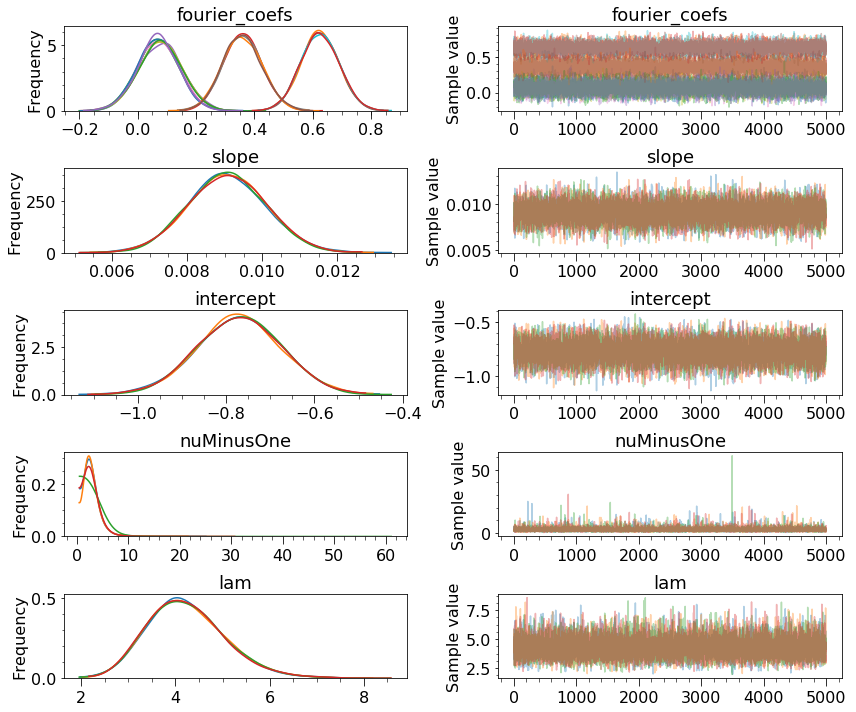

In [23]:
vars_ = ['fourier_coefs', 'slope', 'intercept', 'nuMinusOne', 'lam']
pm.traceplot(trace_3f2, varnames=vars_);

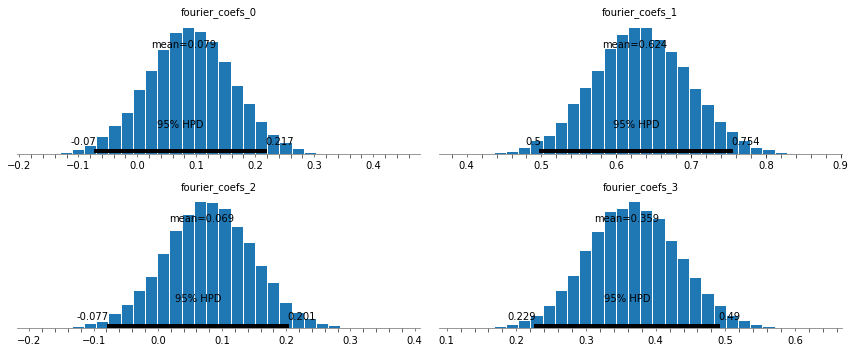

In [24]:
pm.plot_posterior(trace_3f2, varnames=['fourier_coefs']);

In [25]:
N=3
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T
with pm.Model() as m3_f3:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [26]:
with m3_f3:
    trace_3f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_log__, nuMinusOne_log__, intercept, slope, fourier_coefs]
100%|██████████| 10000/10000 [00:23<00:00, 431.09it/s]


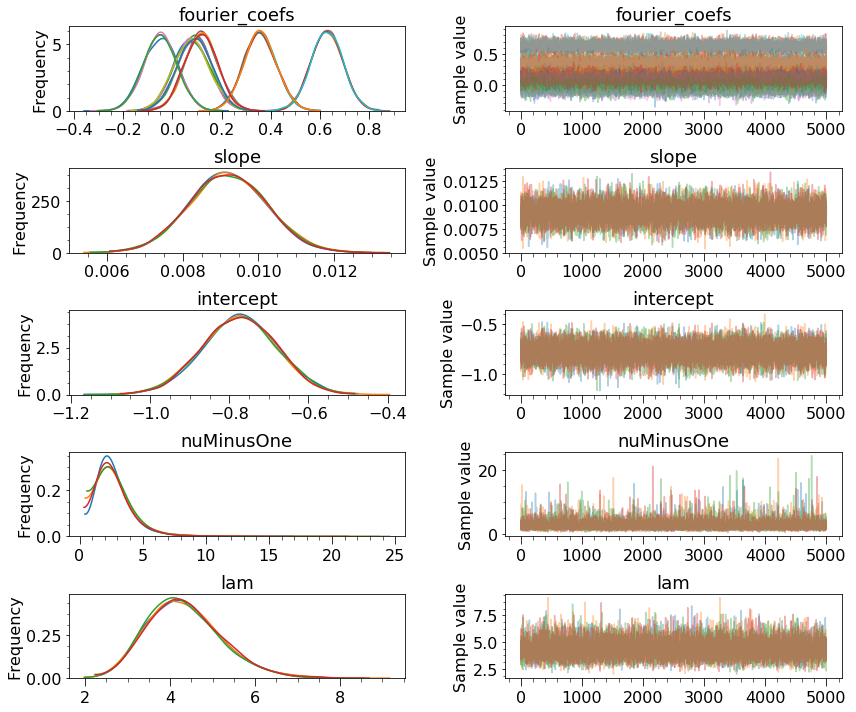

In [27]:
vars_ = ['fourier_coefs', 'slope', 'intercept', 'nuMinusOne', 'lam']
pm.traceplot(trace_3f3, varnames=vars_);

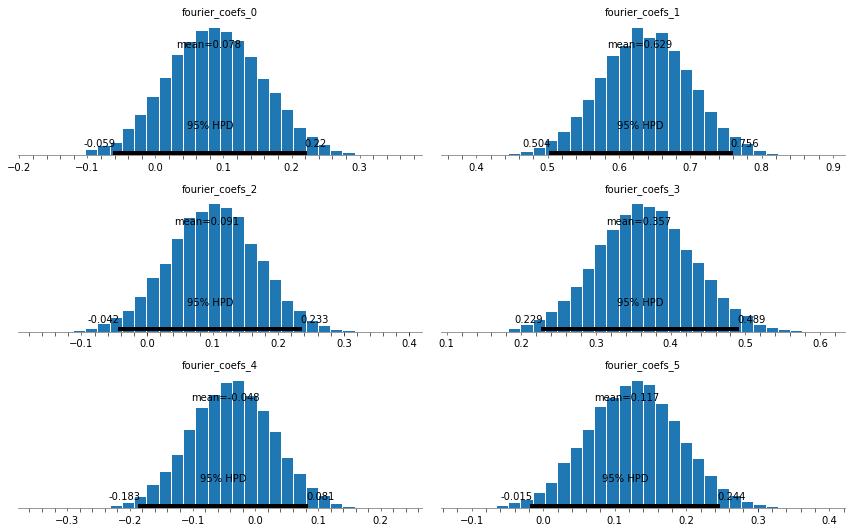

In [29]:
pm.plot_posterior(trace_3f3, varnames=['fourier_coefs']);

In [30]:
N=4
wls = [2*np.pi *k / 12 for k in range(1, N+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(N*2, -1).T
with pm.Model() as m3_f4:
    # seasonality estimation
    f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(N*2))
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [31]:
with m3_f4:
    trace_3f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_log__, nuMinusOne_log__, intercept, slope, fourier_coefs]
100%|██████████| 10000/10000 [00:23<00:00, 420.05it/s]


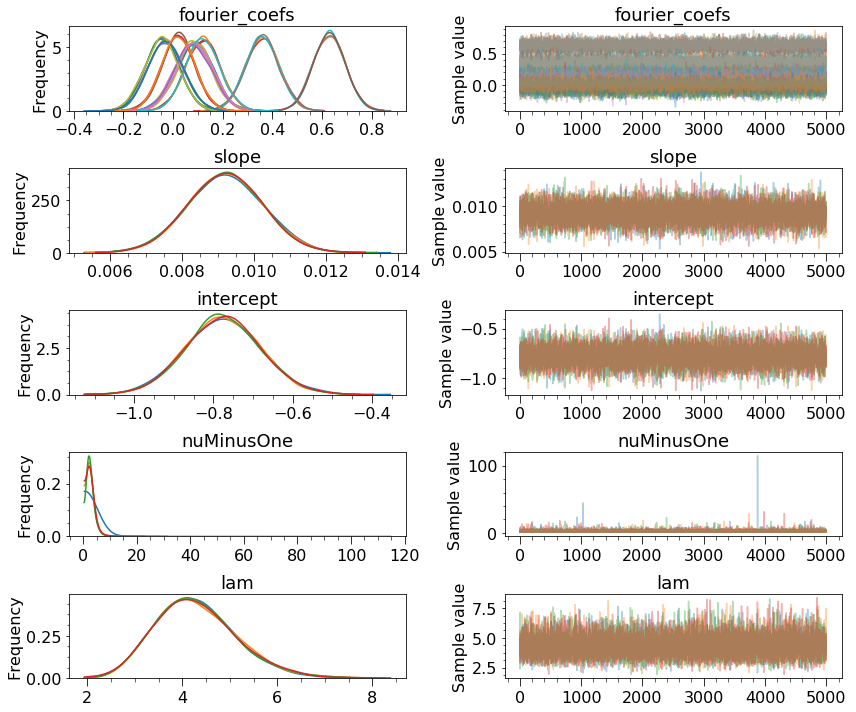

In [32]:
vars_ = ['fourier_coefs', 'slope', 'intercept', 'nuMinusOne', 'lam']
pm.traceplot(trace_3f4, varnames=vars_);

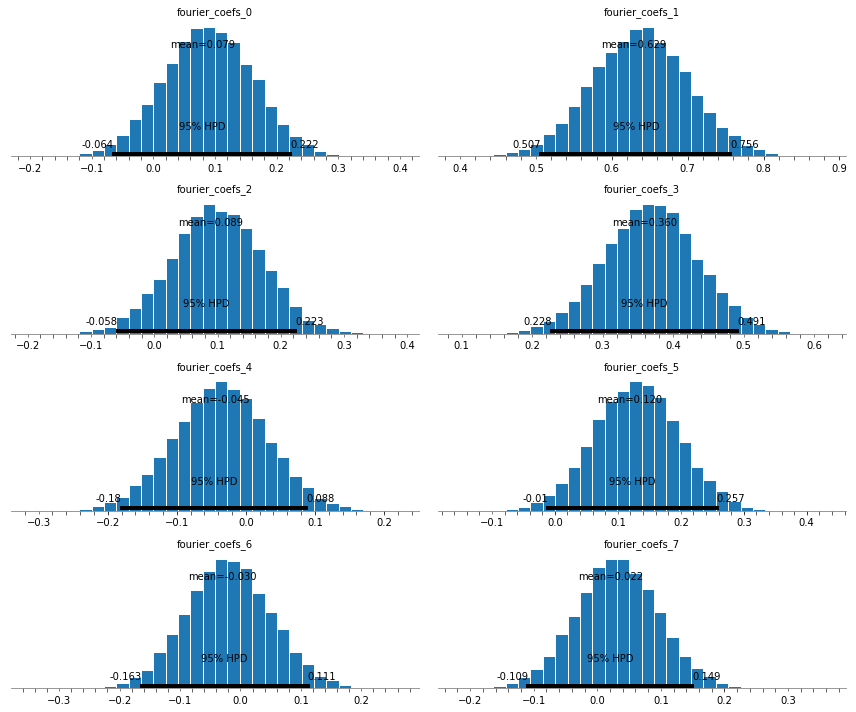

In [34]:
pm.plot_posterior(trace_3f4, varnames=['fourier_coefs']);

In [40]:
m3.name = 'm3_sin_season'
m3_f1.name ='m3_fourierN1'
m3_f2.name = 'm3_fourierN2'
m3_f3.name = 'm3_fourierN3'
m3_f4.name = 'm3_fourierN4'

In [41]:
pm.compare({m3: trace_3, m3_f1: trace_3f1, m3_f2: trace_3f2,
           m3_f3: trace_3f3, m3_f4: trace_3f4})

WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
m3_fourierN2   337.55   8.18      0   0.51  25.99      0        0
m3_fourierN3   337.78   10.2   0.23   0.48  25.93   4.01        0
m3_fourierN4   342.13  12.53   4.58      0  25.85   4.24        0
m3_sin_season  363.55   6.14     26   0.01  26.21  10.16        0
m3_fourierN1   363.66   6.21  26.11      0  26.21  10.12        0

### Trend + Season + Residual

In [96]:
with pm.Model() as m4_normal:
    sd_ = pm.HalfCauchy('sd', 2.5)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.Normal('y_lik', mu=mu_, sd=sd_, observed=y_s)

In [97]:
with m4_normal:
    trace4_normal = pm.sample(7000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, sd_log__]
100%|██████████| 17000/17000 [02:48<00:00, 100.65it/s]
There were 4466 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.299623939245, but should be close to 0.8. Try to increase the number of tuning steps.
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1443 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.651192630223, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 3.70631987617e-14, 

In [21]:
with pm.Model() as m4:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)

In [98]:
with m4:
    trace_4 = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [02:46<00:00, 119.91it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


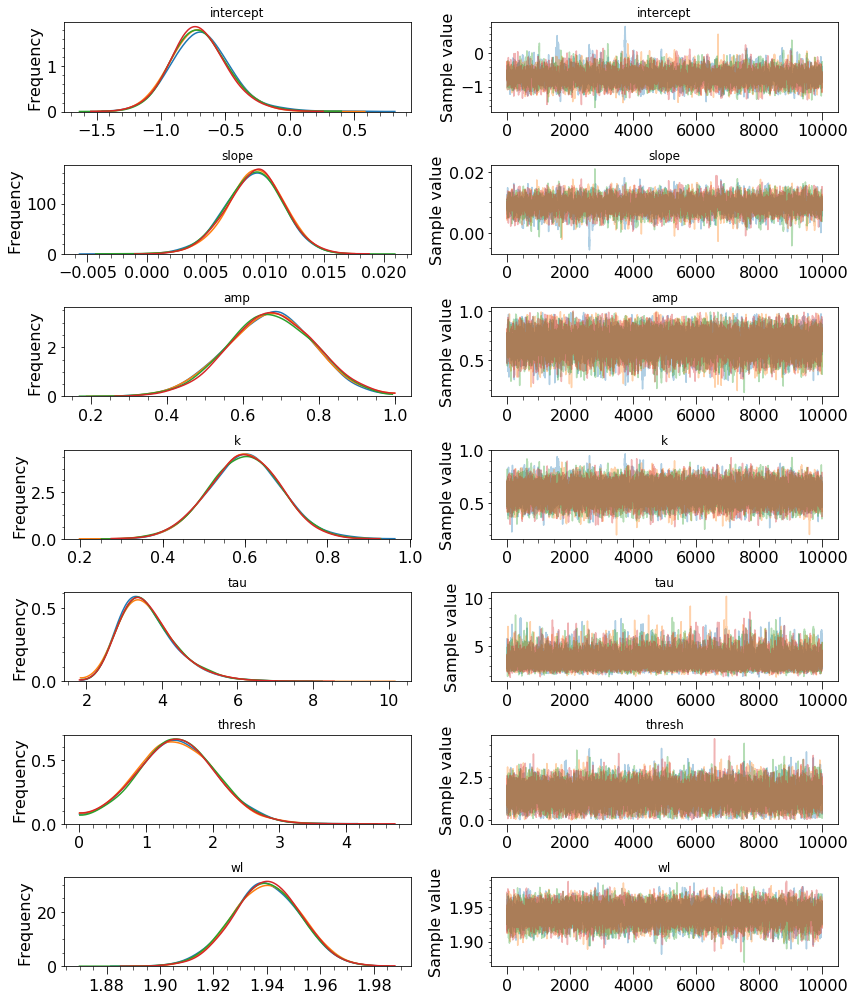

In [99]:
vars_ = ['intercept', 'slope', 'amp', 'k', 'tau', 'thresh', 'wl']
pm.traceplot(trace_4, varnames=vars_);

In [48]:
ts_mod_4 = trace_4.get_values('mu')
ts_mod_4_mu = ts_mod_4.mean(axis=0)
ts_mod_4_hpd = pm.hpd(ts_mod_4)
ts_mod_4_trend = trace_4.get_values('trend')
ts_mod_4_trend_mu = ts_mod_4_trend.mean(axis=0)
ts_mod_4_trend_hpd = pm.hpd(ts_mod_4_trend)
ts_mod_4_season = trace_4.get_values('season')
ts_mod_4_season_mu = ts_mod_4_season.mean(axis=0)
ts_mod_4_season_hpd = pm.hpd(ts_mod_4_season)
ts_mod_4_ar1 = trace_4.get_values('ar1')
ts_mod_4_ar1_mu = ts_mod_4_ar1.mean(axis=0)
ts_mod_4_ar1_hpd = pm.hpd(ts_mod_4_ar1)

In [107]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

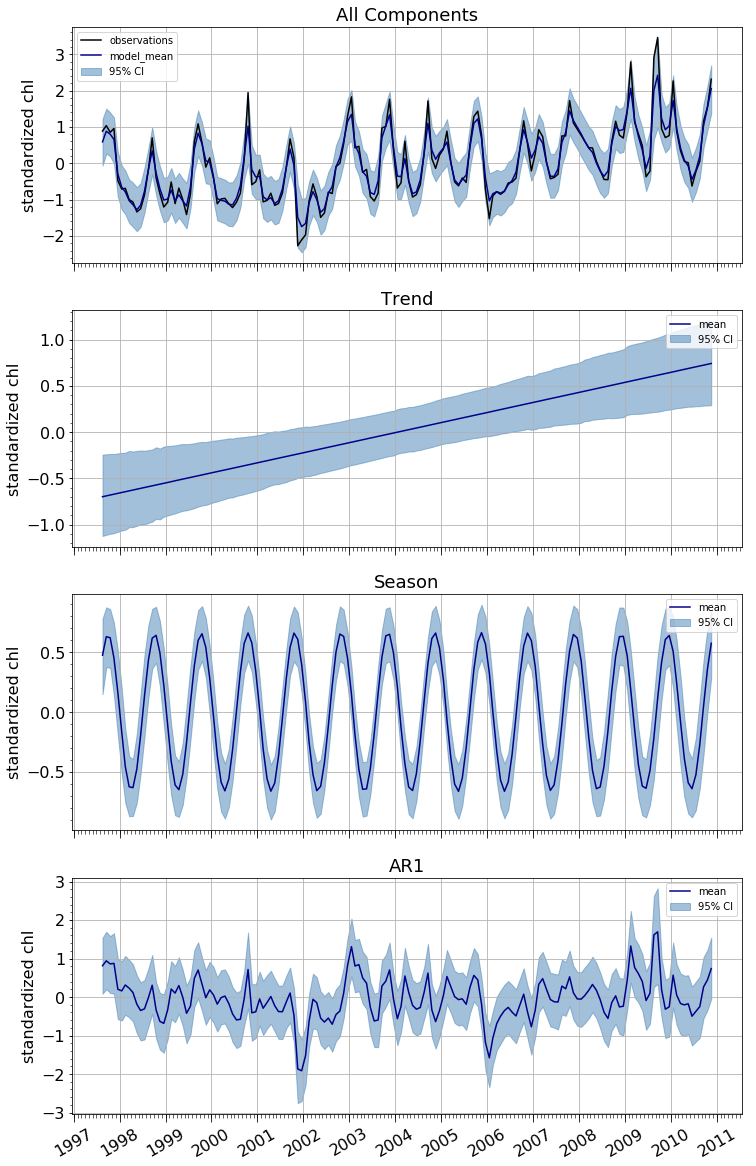

In [108]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))

ylbl = 'standardized chl'
plot_component(ax[0], d_iostz.index, ts_mod_4_mu, hpd_=ts_mod_4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_4_trend_mu, hpd_=ts_mod_4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_4_season_mu, hpd_=ts_mod_4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_4_ar1_mu, hpd_=ts_mod_4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')

#### Inverse transform results of models where standardized data was used

In [ ]:
mod4_mu_us = std_scaler.inverse_transform(ts_mod_4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_mod_4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_mod_4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_mod_4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_mod_4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_mod_4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_mod_4_ar1_mu)

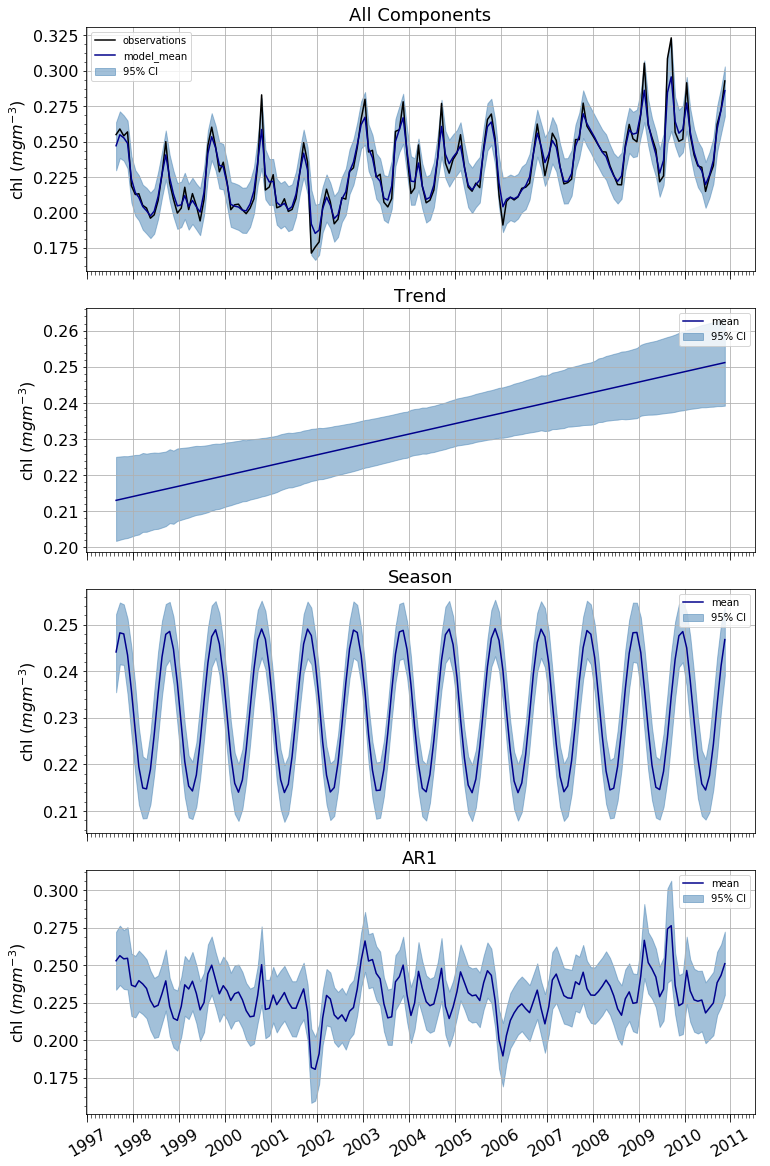

In [112]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')
f.subplots_adjust(hspace=0.15)

In [55]:
pm.summary(trace_4, varnames=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
beta0    -0.691205  0.228410  0.005820 -1.129365 -0.222423  1446.401421   
beta1     0.009049  0.002413  0.000057  0.004287  0.013873  1733.724778   
amp       0.669289  0.116975  0.001959  0.436429  0.897080  3197.556176   
trend_yr  0.108583  0.028959  0.000679  0.051439  0.166474  1733.724778   
k         0.599453  0.087072  0.001188  0.435560  0.777202  4750.895918   
tau       3.607400  0.742816  0.012964  2.326038  5.114566  3716.427496   
thresh    1.471342  0.585814  0.009640  0.306630  2.596705  4034.839474   
wl        1.939310  0.012531  0.000187  1.915154  1.964079  4333.912842   

              Rhat  
beta0     1.002666  
beta1     1.000771  
amp       1.000207  
trend_yr  1.000771  
k         1.000345  
tau       1.000945  
thresh    1.002585  
wl        1.001745

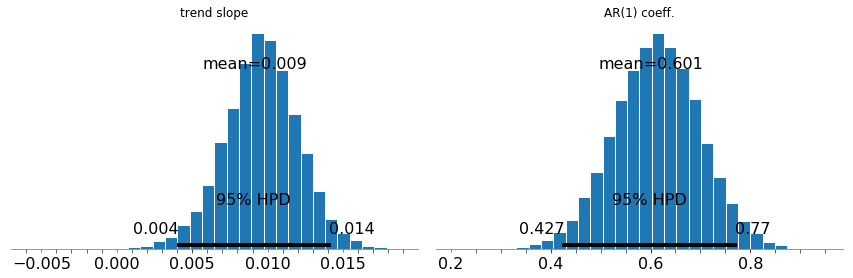

In [119]:
f, axs = pl.subplots(ncols=2, figsize=(12, 4))
pm.plot_posterior(trace_4, varnames=['slope', 'k'], ax=axs, text_size=16, );
axs[0].set_title('trend slope')
axs[1].set_title('AR(1) coeff.')
f.savefig('./figJar/model4_posterior_dists.png', dpi=300)

In [210]:
c1 = 12 # months
c2 = 6 # months
x += 1

In [214]:
with pm.Model() as m5:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    phase = pm.DiscreteUniform('phase', 0, 11, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    cycle_1 = pm.Uniform('cycle_1', 11, 13)
    cycle_2 = pm.Uniform('cycle_2', 5, 7)
    season_1 = amp[0] * tt.cos((2 * PI * x / cycle_1) - phase[0])
    season_2 = amp[1] * tt.cos((2 * PI * x / cycle_2) - phase[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_s)    

In [215]:
with m5:
    trace_5 = pm.sample(10000, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [ar1, tau_log__, k_interval__, intercept, slope, cycle_2_interval__, cycle_1_interval__, amp_log__, lam_log__, nuMinusOne_log__]
>Metropolis: [phase]
100%|██████████| 20000/20000 [03:37<00:00, 91.93it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


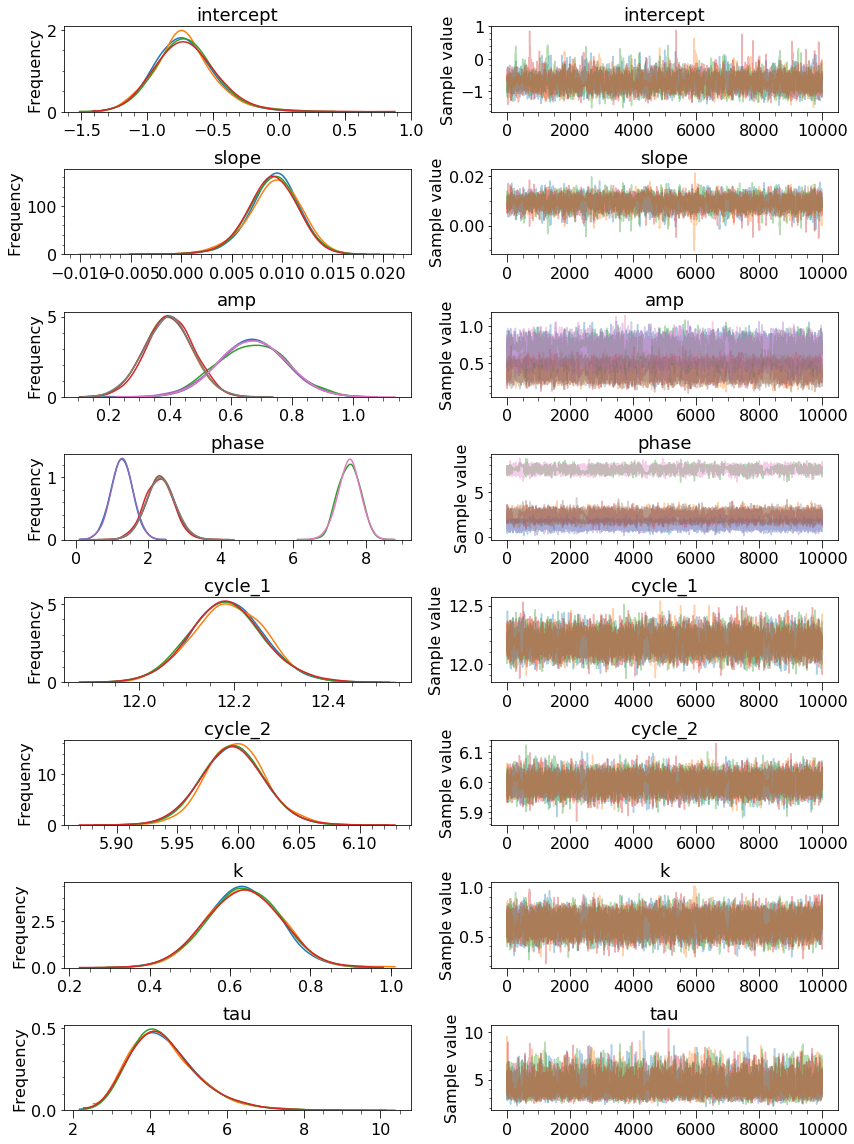

In [213]:
vars_ = ['intercept', 'slope', 'amp', 'phase', 'cycle_1' ,'cycle_2', 'k', 'tau']
pm.traceplot(trace_5, varnames=vars_);

In [178]:
dft5 = pm.summary(trace_5)

In [180]:
dft5.loc[dft5.Rhat>=1.4]

mean        sd  mc_error   hpd_2.5  hpd_97.5     n_eff       Rhat
phase  3.239477  2.731951  0.272014  1.169907  8.239232  2.013667  12.367996

In [65]:
ts_mod_5 = trace_5.get_values('mu_')
ts_mod_5_mu = ts_mod_5.mean(axis=0)
ts_mod_5_hpd = pm.hpd(ts_mod_5)
ts_mod_5_trend = trace_5.get_values('trend')
ts_mod_5_trend_mu = ts_mod_5_trend.mean(axis=0)
ts_mod_5_trend_hpd = pm.hpd(ts_mod_5_trend)
ts_mod_5_season = trace_5.get_values('season')
ts_mod_5_season_mu = ts_mod_5_season.mean(axis=0)
ts_mod_5_season_hpd = pm.hpd(ts_mod_5_season)
ts_mod_5_ar1 = trace_5.get_values('ar1')
ts_mod_5_ar1_mu = ts_mod_5_ar1.mean(axis=0)
ts_mod_5_ar1_hpd = pm.hpd(ts_mod_5_ar1)

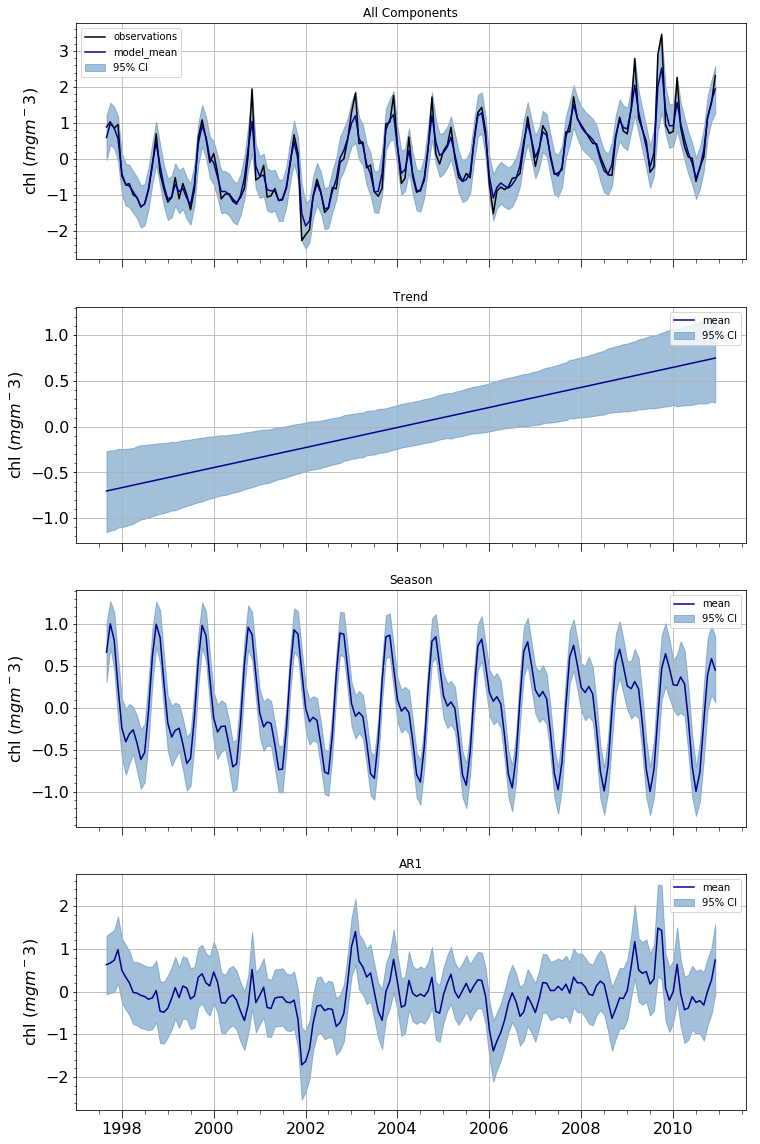

In [71]:
mod5_mu_us = std_scaler.inverse_transform(ts_mod_5_mu)
mod5_hpd_us = std_scaler.inverse_transform(ts_mod_5_hpd)
mod5_trend_hpd_us = std_scaler.inverse_transform(ts_mod_5_trend_hpd)
mod5_trend_mu_us = std_scaler.inverse_transform(ts_mod_5_trend_mu)
mod5_season_hpd_us = std_scaler.inverse_transform(ts_mod_5_season_hpd)
mod5_season_mu_us = std_scaler.inverse_transform(ts_mod_5_season_mu)
mod5_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_5_ar1_hpd)
mod5_ar1_mu_us = std_scaler.inverse_transform(ts_mod_5_ar1_mu)
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))
plot_component(ax[0], d_iostz.index, ts_mod_5_mu, hpd_=ts_mod_5_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
plot_component(ax[1], d_iostz.index, ts_mod_5_trend_mu, hpd_=ts_mod_5_trend_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Trend')
plot_component(ax[2], d_iostz.index, ts_mod_5_season_mu, hpd_=ts_mod_5_season_hpd,
               line_label='mean', y_axis_label='chl $(mg m^-3)$',
              ax_title='Season')
plot_component(ax[3], d_iostz.index, ts_mod_5_ar1_mu, hpd_=ts_mod_5_ar1_hpd,
              line_label='mean', y_axis_label='chl $(mg m^-3)$', ax_title='AR1')

In [69]:
pm.summary(trace_5, varnames=vars_)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  -0.702773  0.226080  0.003271  -1.155062  -0.269016   4582.773666   
slope       0.009147  0.002464  0.000033   0.004332   0.014028   4829.893189   
amp__0      0.667671  0.110026  0.001155   0.450880   0.884505   8872.234845   
amp__1      0.393080  0.079475  0.000726   0.235134   0.549326  15881.738046   
thresh1    10.480064  0.469853  0.004725   9.573454  11.410631  12139.127125   
thresh2    11.552481  0.319111  0.002500  10.936431  12.193348  17125.299113   
wl_1        1.941707  0.011422  0.000106   1.919245   1.964353  11516.422607   
wl_2        0.955897  0.003947  0.000034   0.948013   0.963453  15734.391590   

               Rhat  
intercept  1.000160  
slope      1.000418  
amp__0     1.000059  
amp__1     1.000081  
thresh1    1.000228  
thresh2    1.000086  
wl_1       1.000208  
wl_2       1.000164

#### Modeling w/ missing data imputation

In [126]:
df[['IOSTZ']].resample('MS').mean().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1997-09-01 to 2010-12-01
Freq: MS
Data columns (total 1 columns):
IOSTZ    155 non-null float64
dtypes: float64(1)
memory usage: 2.5 KB


In [144]:
y_w_nan = np.ma.array(data=df.IOSTZ.resample('MS').mean(),
                      mask=df.IOSTZ.resample('MS').mean().isnull(),
                     fill_value=-999)
nan_scaler = namedtuple('nan_scaler', ['mean_', 'std_'])
nan_scaler.mean_ = y_w_nan.mean()
nan_scaler.std_ = y_w_nan.std()
y_w_nan_s = (y_w_nan - nan_scaler.mean_) / nan_scaler.std_

In [146]:
with pm.Model() as m4i:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)

In [147]:
with m4i:
    trace_4i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [03:02<00:00, 109.84it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.69781933688, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71646233209, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


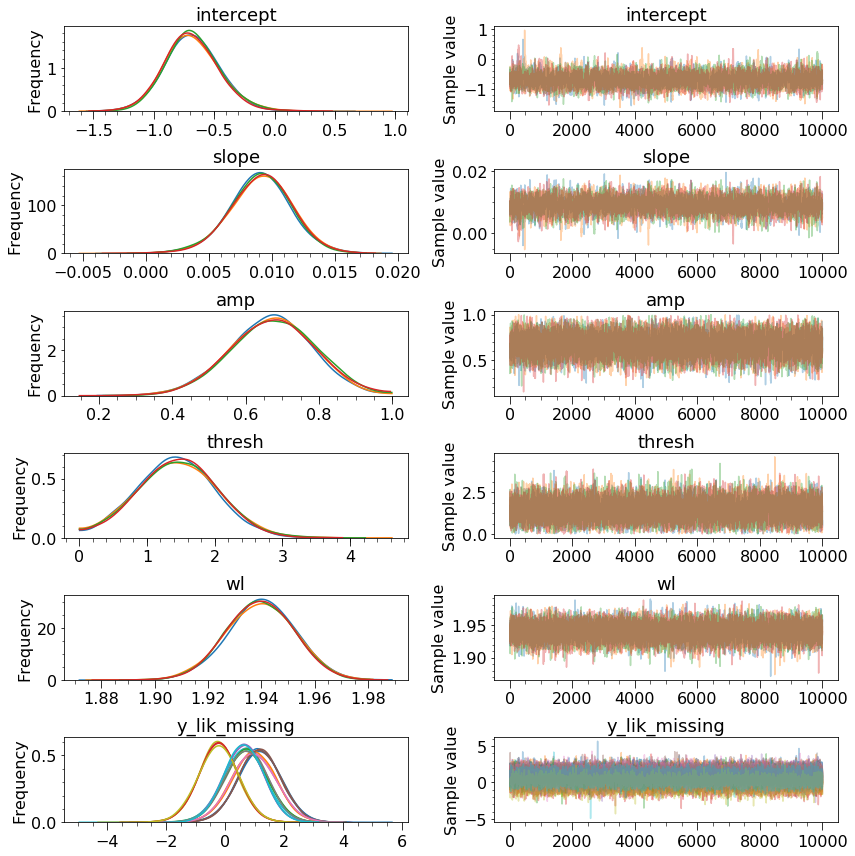

In [243]:
vars_ = ['intercept', 'slope', 'amp', 'thresh', 'wl', 'y_lik_missing']
pm.traceplot(trace_4i, varnames=vars_);

In [244]:
pm.summary(trace_4i, varnames=vars_)

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept        -0.678875  0.224528  0.004561 -1.112781 -0.228108   
slope             0.009113  0.002447  0.000046  0.004178  0.013920   
amp               0.672759  0.114928  0.001340  0.441977  0.892130   
thresh            1.447370  0.584646  0.006425  0.289872  2.574037   
wl                1.939780  0.012613  0.000140  1.915247  1.964524   
y_lik_missing__0  1.166311  0.710226  0.004355 -0.219344  2.560616   
y_lik_missing__1  0.977485  0.743502  0.004838 -0.492352  2.421179   
y_lik_missing__2  0.711867  0.707809  0.004417 -0.682458  2.093423   
y_lik_missing__3 -0.222968  0.656253  0.003800 -1.539396  1.040424   
y_lik_missing__4  0.637990  0.663471  0.003682 -0.668910  1.927358   

                         n_eff      Rhat  
intercept          3116.003596  1.000485  
slope              3576.453879  1.000292  
amp                7069.847140  1.000799  
thresh             8414.914112  1.000438  
wl                 8984.735723  1.000503  
y_lik_missing__0  23333.505362  1.000090  
y_lik_missing__1  21163.169051  1.000011  
y_lik_missing__2  21569.211968  1.000060  
y_lik_missing__3  30058.771240  1.000005  
y_lik_missing__4  32088.705741  0.999994

In [192]:
d_iostz_s = (df.IOSTZ  - df.IOSTZ.mean()) / df.IOSTZ.std()
d_iostz_si = d_iostz_s.resample('MS').mean().interpolate()

In [198]:
np.argwhere(y_w_nan_s.mask)

array([[124],
       [125],
       [126],
       [130],
       [140]])

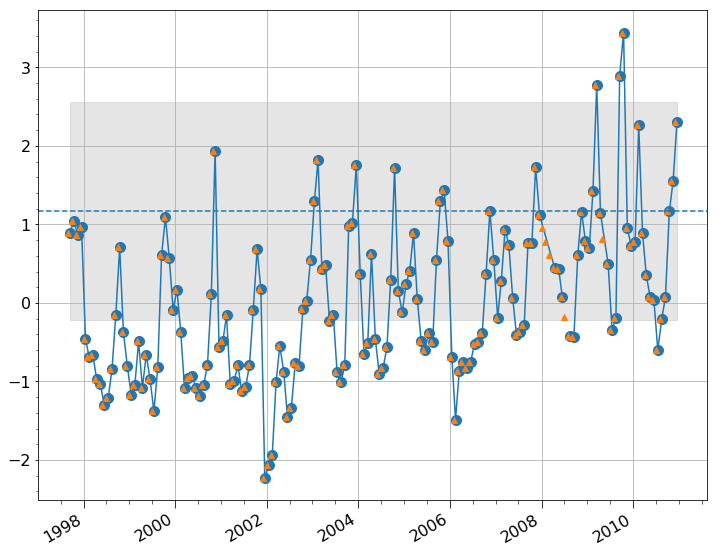

In [202]:
_, ax = pl.subplots(figsize=(12, 10))

d_iostz_s.plot(marker='o', markersize=10, ax=ax)
d_iostz_si.plot(marker='^', ls='', ax=ax)
ax.grid()
ax.axhline(y=1.166, ls='--')
ax.fill_between(d_iostz_s.index, y1=-0.219, y2=2.561, color='gray', alpha=0.2)

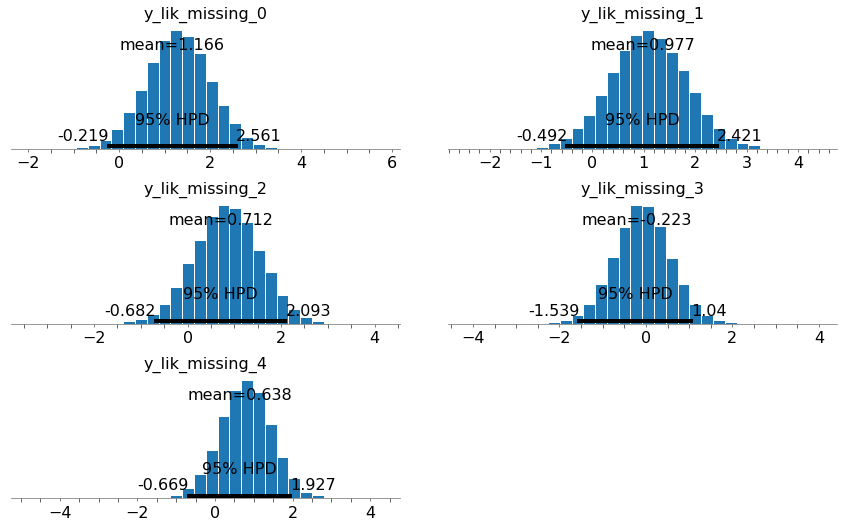

In [185]:
pm.plot_posterior(trace_4i, varnames=['y_lik_missing'],text_size=16);

In [166]:
with pm.Model() as m5i:
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Normal('thresh', 10, shape=2)
    amp = pm.HalfNormal('amp', 5, shape=2)
    wl = pm.Uniform('wl_1', 0, 5, shape=2)
    season_1 = amp[0] * tt.sin((x - thresh[0]) / wl[0])
    season_2 = amp[1] * tt.sin((x - thresh[1]) / wl[1])
    season = pm.Deterministic('season', season_1 + season_2)
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
       
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)

    #e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    #mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu_', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)    

In [162]:
with m5i:
    trace_5i = pm.sample(10000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, wl_2_interval__, wl_1_interval__, amp_log__, thresh2, thresh1, lam_log__, nuMinusOne_log__]
100%|██████████| 20000/20000 [04:49<00:00, 69.07it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


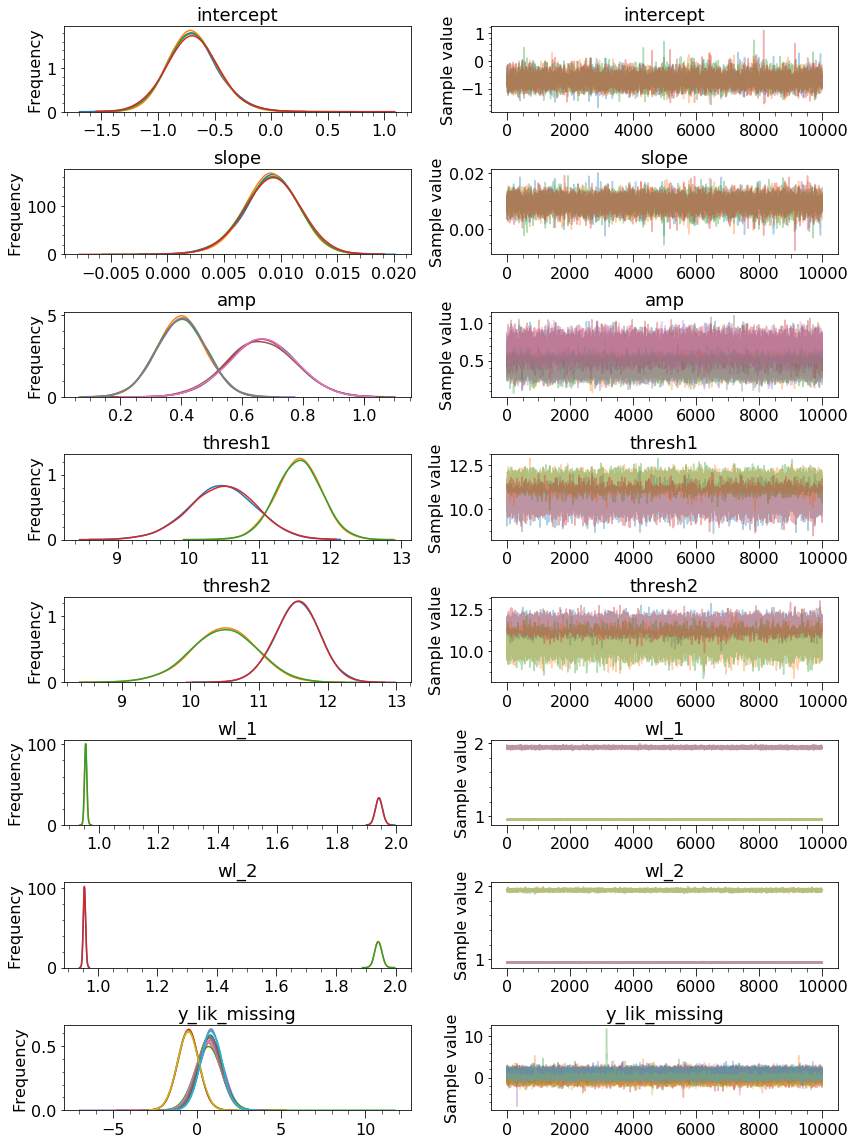

In [165]:
vars_ = ['intercept', 'slope', 'amp', 'thresh1', 'thresh2', 'wl_1', 'wl_2',
         'y_lik_missing']
pm.traceplot(trace_5i, varnames=vars_);

### Local linear  modeling

In [217]:
numobs = y_s.size

In [219]:
with pm.Model() as m6:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=delta_t, sd=1, observed=y_s)

In [220]:
with m6:
    trace_6 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta_t]
100%|██████████| 10000/10000 [00:23<00:00, 425.11it/s]


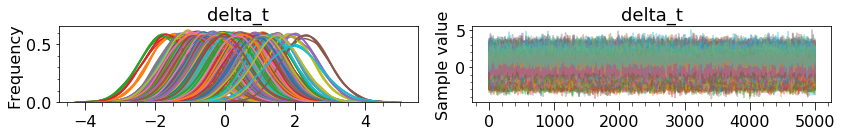

In [223]:
pm.traceplot(trace_6);

In [227]:
y_ppc6 = pm.sample_ppc(trace_6, model=m6)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6327.71it/s]


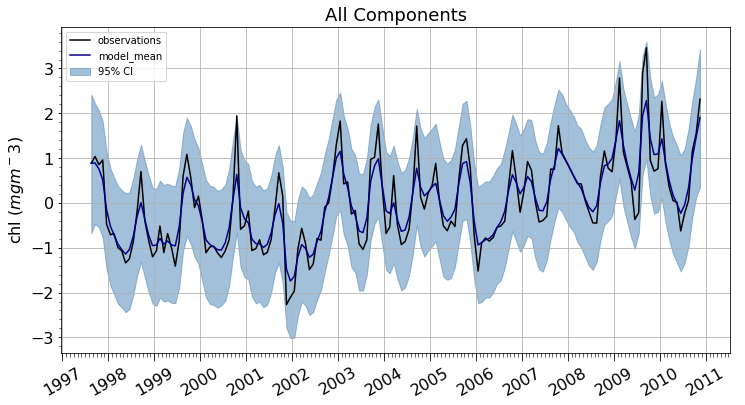

In [222]:
ts_mod_6 = trace_6.get_values('delta_t')
ts_mod_6_mu = ts_mod_6.mean(axis=0)
ts_mod_6_hpd = pm.hpd(ts_mod_6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, ts_mod_6_mu, hpd_=ts_mod_6_hpd,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

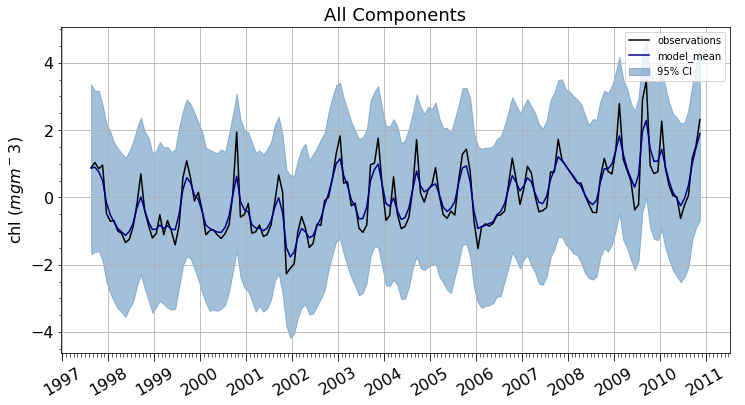

In [231]:
y_m6 = y_ppc6.mean(axis=0)
hpd6 = pm.hpd(y_ppc6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m6, hpd_=hpd6,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Local linear trend modeling

In [224]:
with pm.Model() as m7:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs-1)
    nu_t = pm.GaussianRandomWalk('nu_t', mu=delta_t, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=nu_t, sd=1, observed=y_s)

In [225]:
with m7:
    trace_7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_t, delta_t]
100%|██████████| 10000/10000 [00:19<00:00, 505.28it/s]


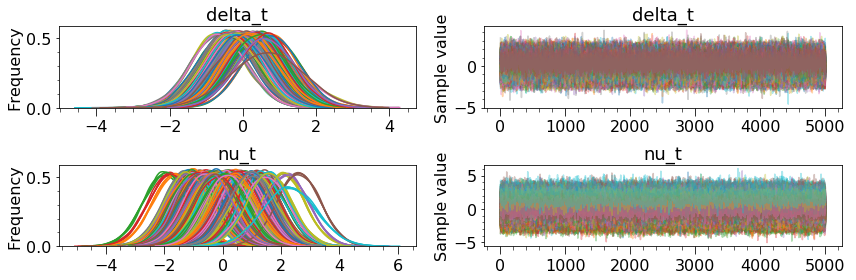

In [226]:
pm.traceplot(trace_7);

In [232]:
y_ppc7 = pm.sample_ppc(trace_7, model=m7)['y_t']

100%|██████████| 5000/5000 [00:00<00:00, 6284.92it/s]


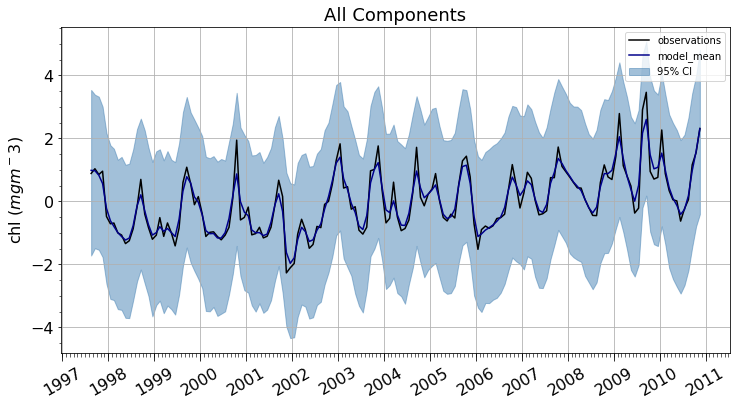

In [233]:
y_m7 = y_ppc7.mean(axis=0)
hpd7 = pm.hpd(y_ppc7)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m7, hpd_=hpd7,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Pickle model results and scaler

In [88]:
m5.name = 'm5'
m4.name = 'm4'
m4i.name = 'm4_imputed'
m5i.name = 'm5_imputed'
resDict = dict(models=dict(m4=m4, m5=m5, m4i=m4i, m5i=m5i),
               traces=dict(m4=trace_4, m5=trace_5, m4i=trace_4i, m5i),
               scaler=std_scaler)
with open('./pikleJar/iostz_bayMdl.pkl', 'wb') as f:
    pickle.dump(resDict, f)

'm5'

In [79]:
resDict.keys(), resDict['models'].keys(), resDict['traces'].keys()

(dict_keys(['models', 'traces', 'scaler']),
 dict_keys(['m4', 'm5']),
 dict_keys(['m4', 'm5']))

In [94]:
pm.compare({m4:trace_4, m5:trace_5})

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE   dSE var_warn
m5  239.66  73.83      0      1  20.75     0        1
m4  254.37  77.72  14.71      0  20.88  5.75        1

In [95]:
pm.compare({m4:trace_4, m5:trace_5}, ic='LOO')

/accounts/ekarakoy/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


LOO   pLOO   dLOO weight     SE   dSE shape_warn
m5  268.39  88.19      0      1  21.25     0          1
m4  286.86  93.96  18.47      0  21.22  6.28          1